In [1]:
import matplotlib.pyplot as plt

import numpy as np
import time
import itertools
import scipy.stats as stats

from ProbabilisticDiffusion import Diffusion
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import sys

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)
def tweedies(data, dist, plot_grad=True, plot_density=True, plot_tweedies=True, min_val=-0.5, max_val=0.5):
    # Tweedies formula
    covariance = np.cov(data.numpy().T)
    with tf.GradientTape() as tape:
        tape.watch(data)
        prob = dist.prob(data)
        gradients = tape.gradient(prob, data)
    
    gradients = gradients.numpy()
    prob = prob.numpy()
    prob_div = prob.reshape((len(gradients), 1))
    tweedies = data.numpy() + np.clip((covariance @ (gradients / prob_div).T).T, min_val, max_val) #Clip quotient for stability
    # Plot flags
    if plot_grad:
        sum_grads = np.sum(gradients, axis=1)
        plt.scatter(data[:,0], data[:,1], c=np.clip(sum_grads, min_val, max_val), s=7 , cmap='Spectral')
        plt.title('Gradients')
        cbar = plt.colorbar()
        plt.show()
    if plot_density:
        plt.scatter(data[:,0], data[:,1], c=prob, s=7 , cmap='Spectral')
        plt.title('Density')
        cbar = plt.colorbar()
        plt.show()
    if plot_tweedies:
        plt.scatter(data[:,0], data[:,1], c=sum(np.clip((gradients/prob_div).T, min_val, max_val)), s=7 , cmap='Spectral')
        plt.title('Quotient Term')
        cbar = plt.colorbar()
        plt.show()
        plt.scatter(data[:,0], data[:,1], c=sum(np.clip((covariance @ (gradients / prob_div).T), min_val, max_val)), s=7 , cmap='Spectral')
        plt.title('Tweedies Term')
        cbar = plt.colorbar()
        plt.show()
    return tweedies


def generate_circular(n, size):
    radians = np.random.uniform(low=0.0, high=2*np.pi, size=n)
    x = size * np.cos(radians)
    y = size * np.sin(radians)
    return x, y

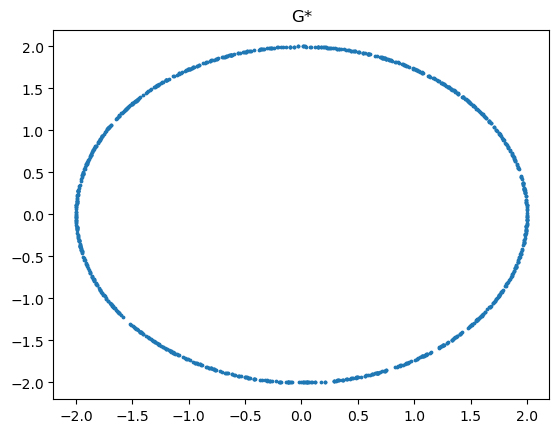

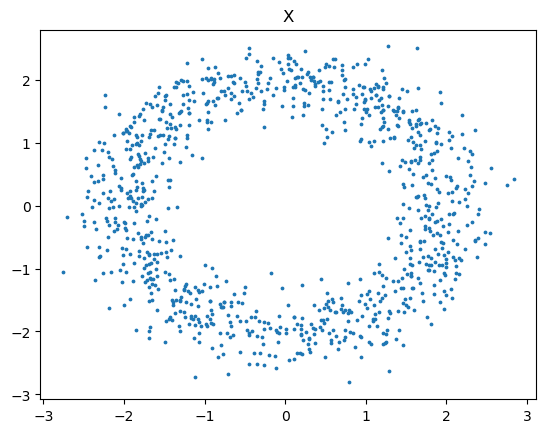

In [2]:
n=1000
x_orig, y_orig = generate_circular(n, 2)

plt.scatter(x_orig, y_orig, s=3)
plt.title('G*')
plt.show()

x = x_orig + np.random.normal(loc=0.0, scale=0.3, size=n)
y = y_orig + np.random.normal(loc=0.0, scale=0.3, size=n)

plt.scatter(x, y, s=3)
plt.title('X')
plt.show()

In [3]:
data = torch.stack([torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)],dim=1)

In [4]:
n_steps=200
model = ConditionalModel(n_steps)
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
diffusion = Diffusion(data, n_steps,
                 1e-5, 1e-2, 'linear',
                 model, loss, optimizer)

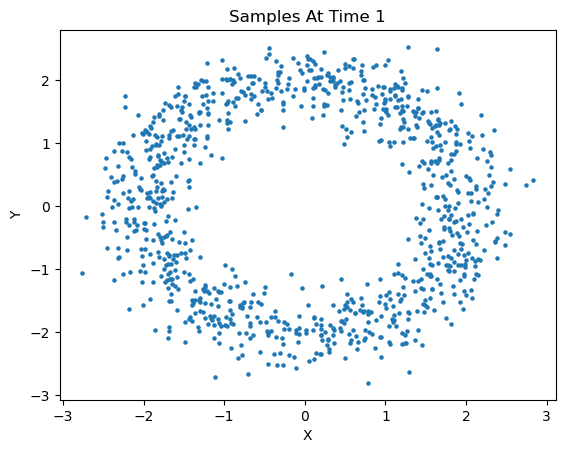

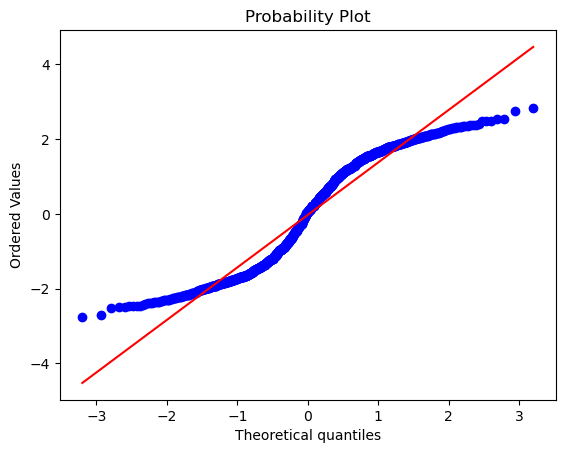

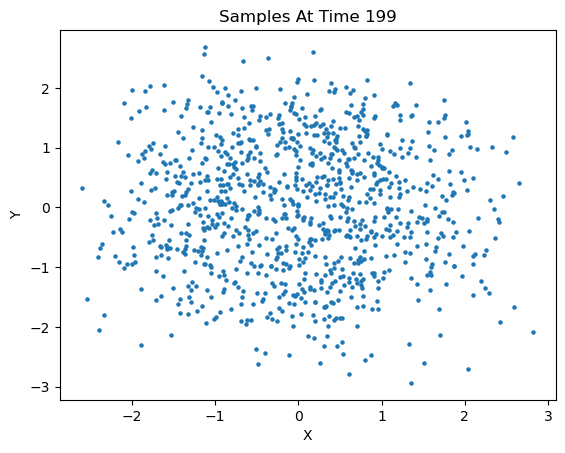

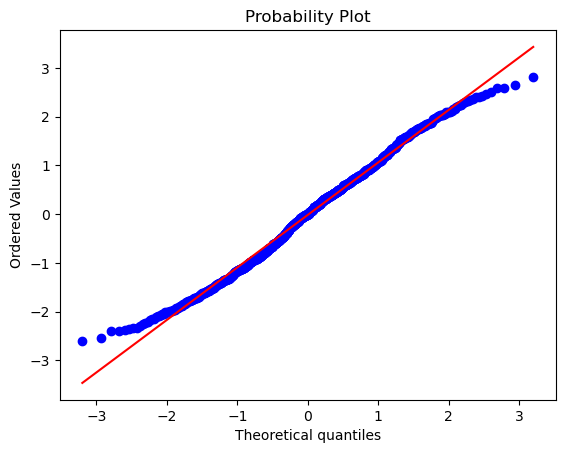

In [5]:
noised = diffusion.forward(1, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()
noised = diffusion.forward(199, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()

100%|█████████████████████████| 10000/10000 [02:58<00:00, 55.90it/s, loss=0.750]


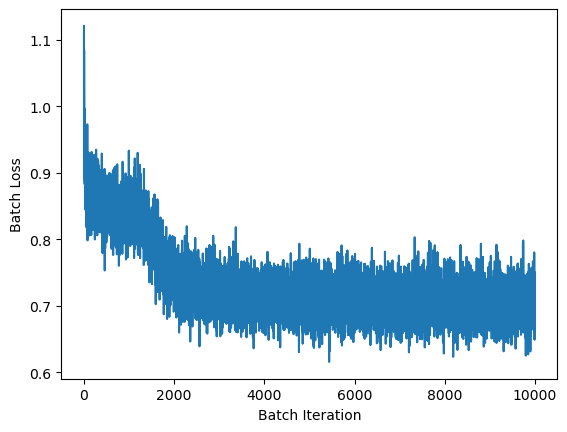

In [6]:
diffusion.train(1000, 10000)

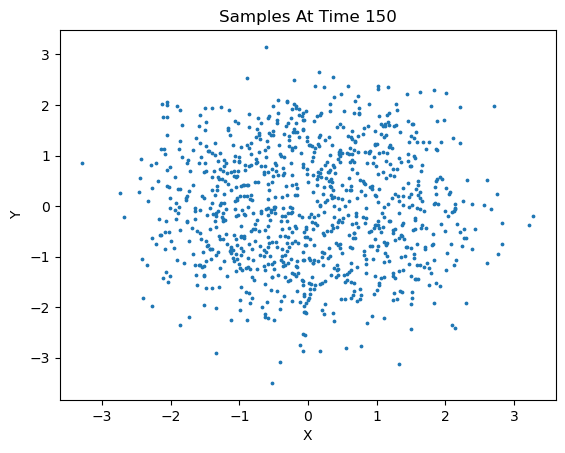

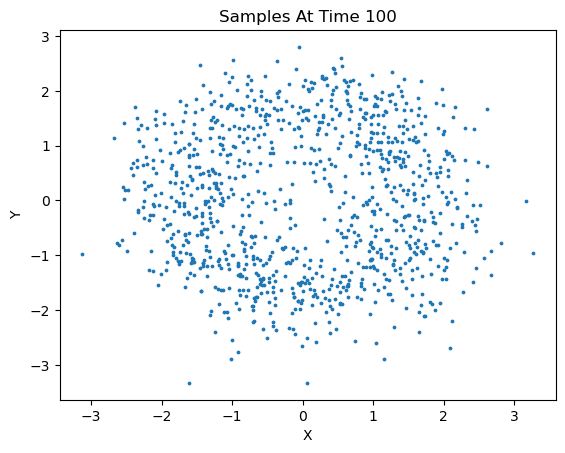

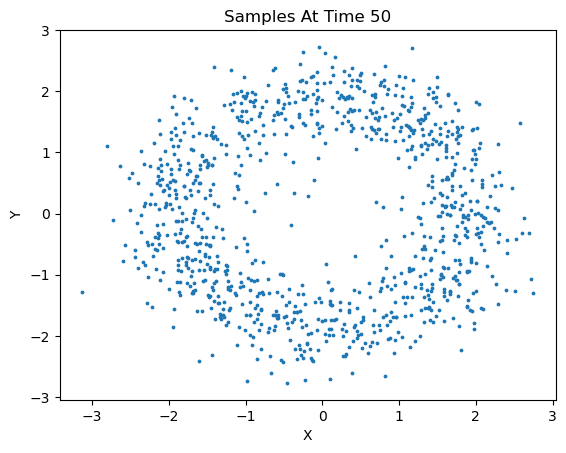

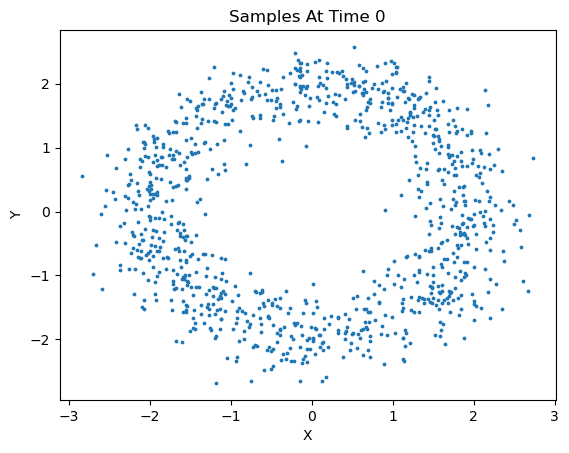

In [7]:
new_x = diffusion.sample(1000, 50, s=3)

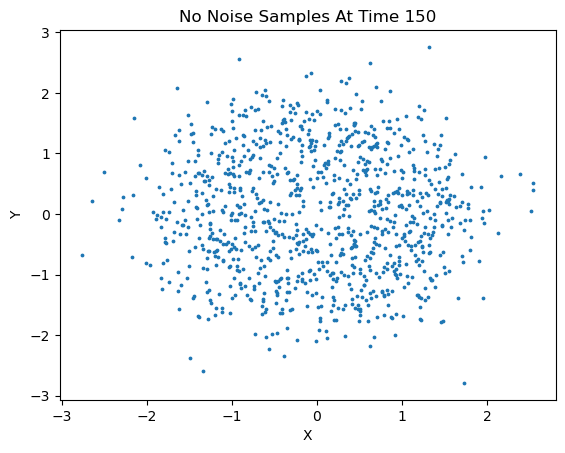

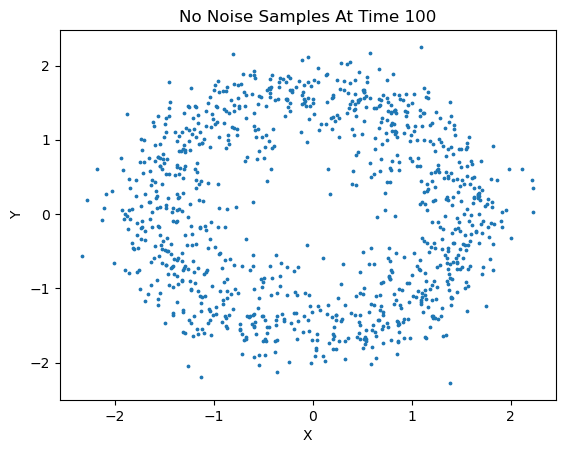

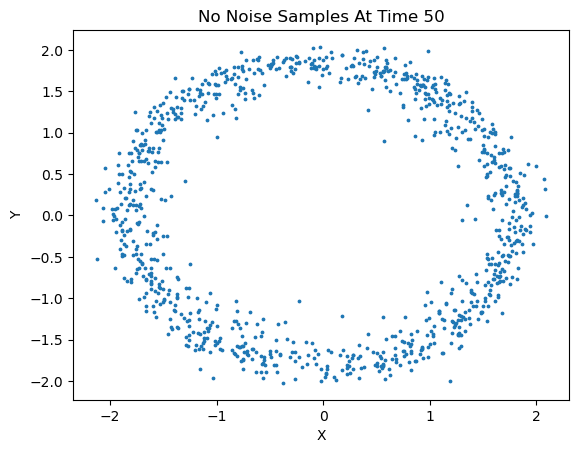

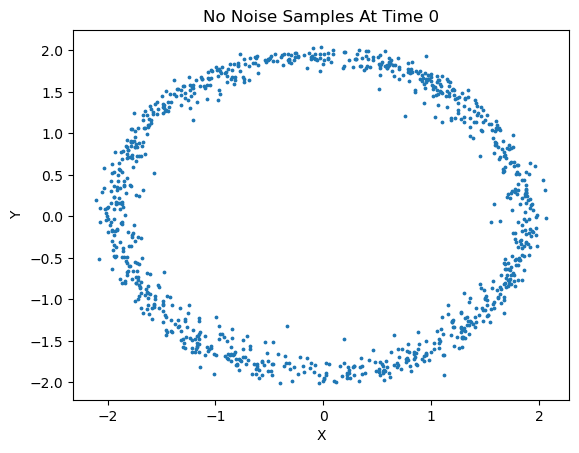

In [8]:
new_x = diffusion.sample(1000, 50, no_noise=True, s=3)

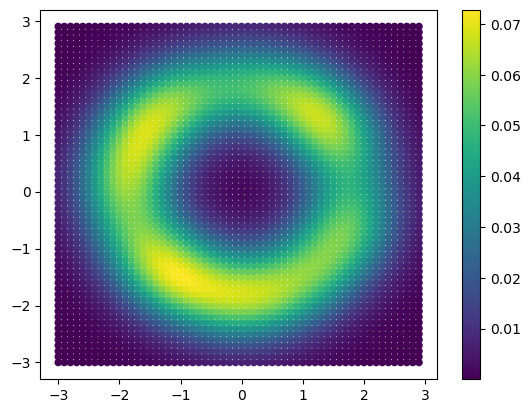

In [9]:
x_grid = torch.arange(-3,3,0.1)
y_grid = torch.arange(-3,3,0.1)
grid = torch.cartesian_prod(x_grid, y_grid)

probabilities = diffusion.estimate_distribution(1000, grid, torch.tensor([0.3, 0.3]))

plt.scatter(grid[:,0], grid[:,1], c=probabilities, s=20)
plt.colorbar()
plt.show()